# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-5-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

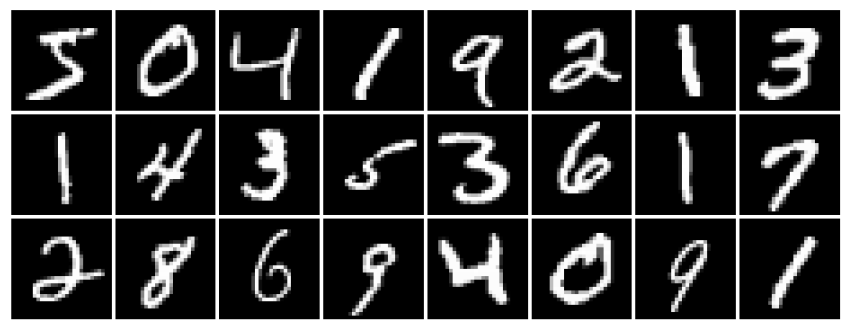

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


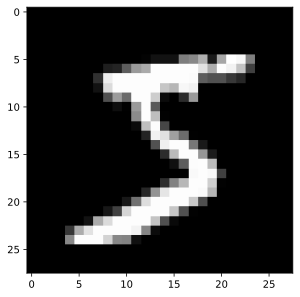

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.0664, -0.1614, -0.2839, -0.0453, -0.2189,  0.2230, -0.2127, -0.3309,
         -0.0917, -0.0387],
        [ 0.0029, -0.0305, -0.0791,  0.0182,  0.0434,  0.3987,  0.0026, -0.1508,
          0.1572, -0.1244],
        [-0.0365, -0.3803, -0.0417, -0.0252, -0.1298, -0.0682,  0.0432, -0.2391,
         -0.0628,  0.0013],
        [ 0.1192,  0.0317, -0.0208,  0.0792,  0.0408, -0.0594, -0.2983,  0.1413,
         -0.1265, -0.0655],
        [ 0.0993, -0.1621, -0.0069,  0.0141, -0.1705,  0.0762,  0.1028,  0.1847,
         -0.0057,  0.0753]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [12]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-7cc2wx06
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-7cc2wx06
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3053, grad_fn=<NllLossBackward0>)

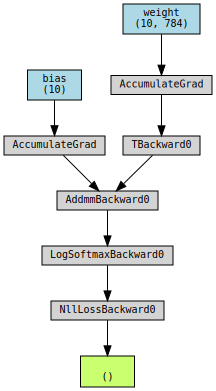

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

Época 1 de 100 => perda: 2.30530, acurária: 0.0762


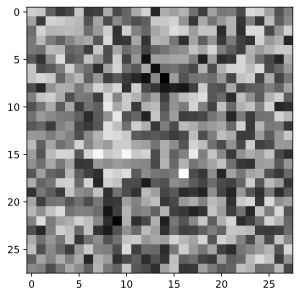

Época 2 de 100 => perda: 1.83259, acurária: 0.6599


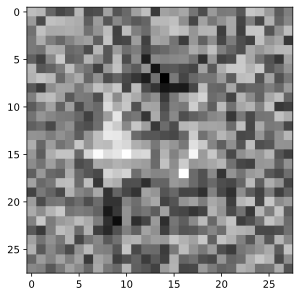

Época 3 de 100 => perda: 1.51306, acurária: 0.7501


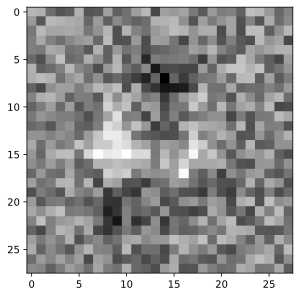

Época 4 de 100 => perda: 1.30193, acurária: 0.7777


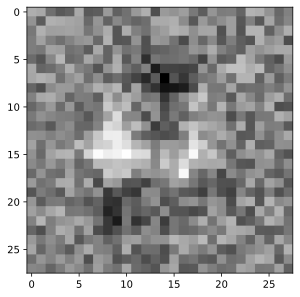

Época 5 de 100 => perda: 1.15677, acurária: 0.7976


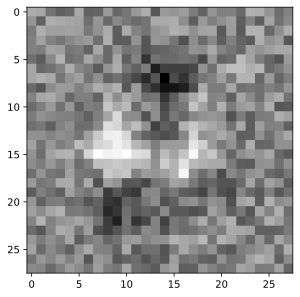

Época 6 de 100 => perda: 1.05122, acurária: 0.8107


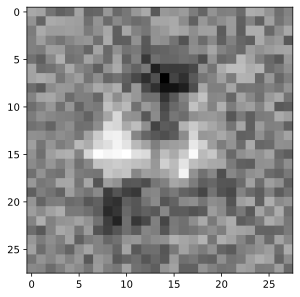

Época 7 de 100 => perda: 0.97250, acurária: 0.8159


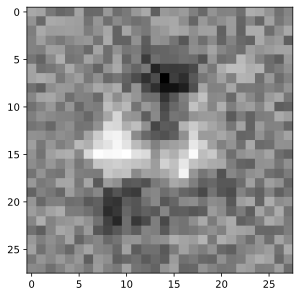

Época 8 de 100 => perda: 0.90985, acurária: 0.8246


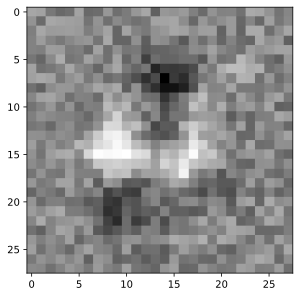

Época 9 de 100 => perda: 0.86019, acurária: 0.8284


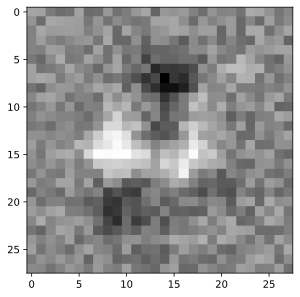

Época 10 de 100 => perda: 0.81824, acurária: 0.8352


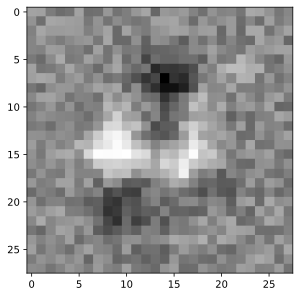

Época 11 de 100 => perda: 0.78355, acurária: 0.8381


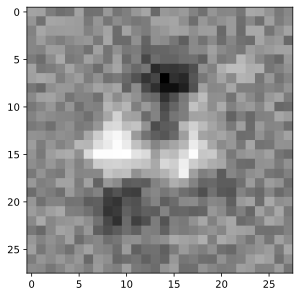

Época 12 de 100 => perda: 0.75354, acurária: 0.8423


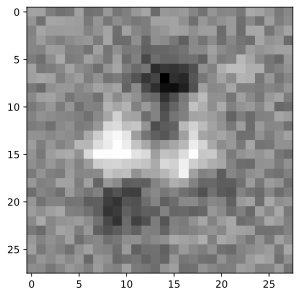

Época 13 de 100 => perda: 0.72789, acurária: 0.8451


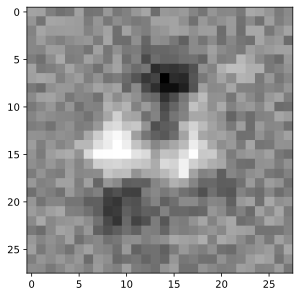

Época 14 de 100 => perda: 0.70543, acurária: 0.8487


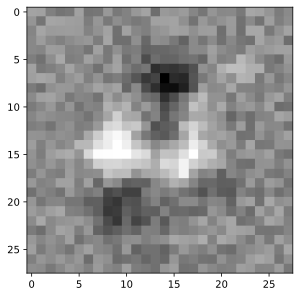

Época 15 de 100 => perda: 0.68573, acurária: 0.8503


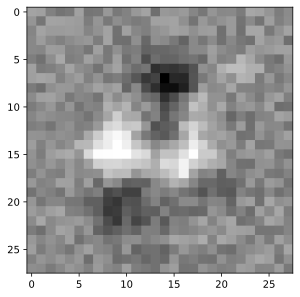

Época 16 de 100 => perda: 0.66822, acurária: 0.8529


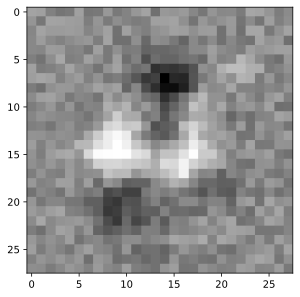

Época 17 de 100 => perda: 0.65255, acurária: 0.8551


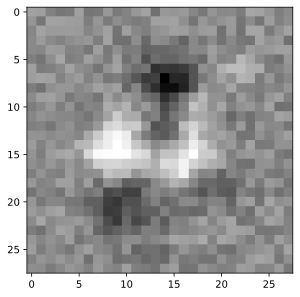

Época 18 de 100 => perda: 0.63842, acurária: 0.8568


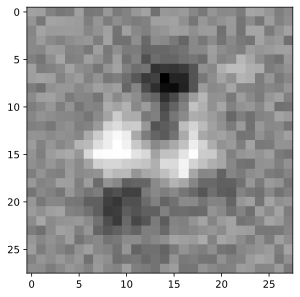

Época 19 de 100 => perda: 0.62559, acurária: 0.8583


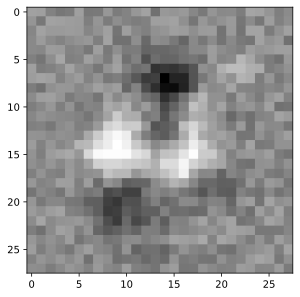

Época 20 de 100 => perda: 0.61388, acurária: 0.8598


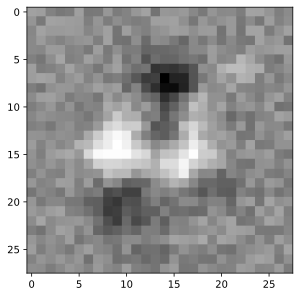

Época 21 de 100 => perda: 0.60314, acurária: 0.8608


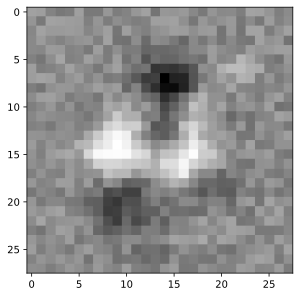

Época 22 de 100 => perda: 0.59324, acurária: 0.8621


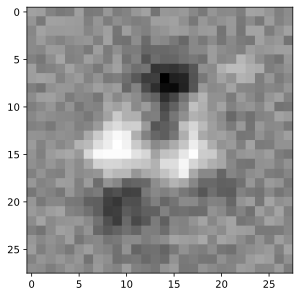

Época 23 de 100 => perda: 0.58408, acurária: 0.8632


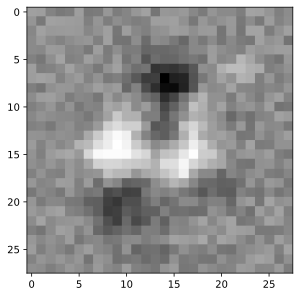

Época 24 de 100 => perda: 0.57557, acurária: 0.8645


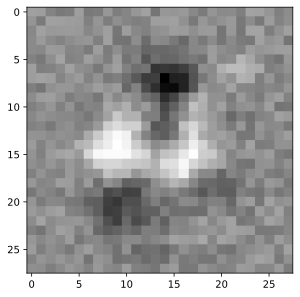

Época 25 de 100 => perda: 0.56765, acurária: 0.8655


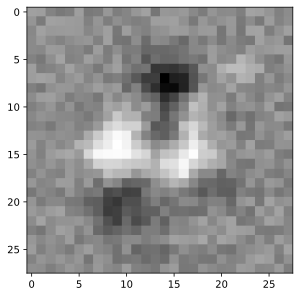

Época 26 de 100 => perda: 0.56025, acurária: 0.8662


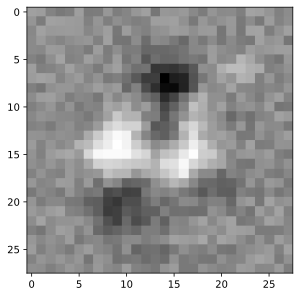

Época 27 de 100 => perda: 0.55332, acurária: 0.8671


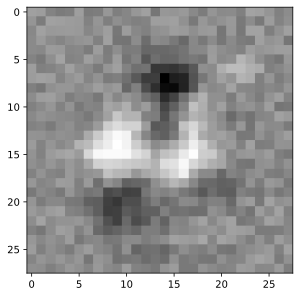

Época 28 de 100 => perda: 0.54681, acurária: 0.8682


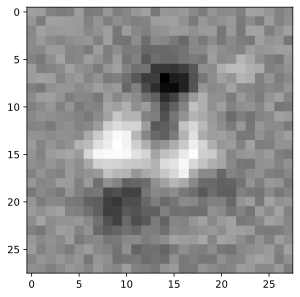

Época 29 de 100 => perda: 0.54068, acurária: 0.8692


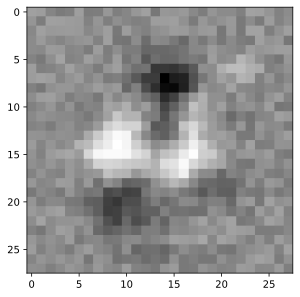

Época 30 de 100 => perda: 0.53490, acurária: 0.8699


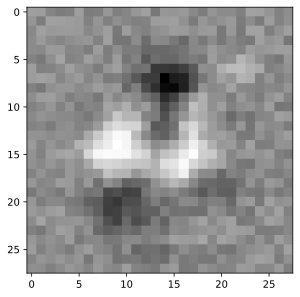

Época 31 de 100 => perda: 0.52944, acurária: 0.8706


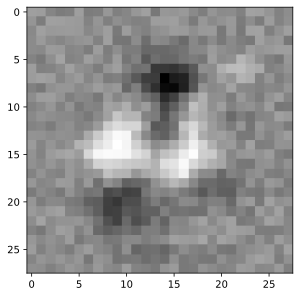

Época 32 de 100 => perda: 0.52426, acurária: 0.8715


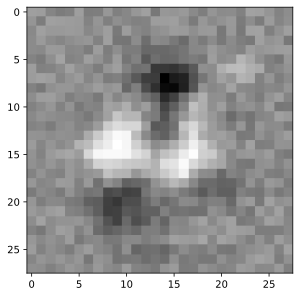

Época 33 de 100 => perda: 0.51935, acurária: 0.8722


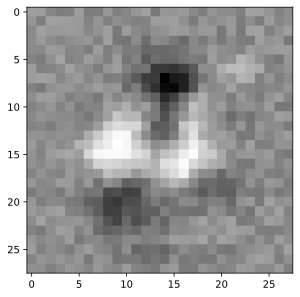

Época 34 de 100 => perda: 0.51468, acurária: 0.8732


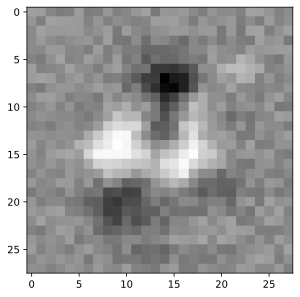

Época 35 de 100 => perda: 0.51023, acurária: 0.8738


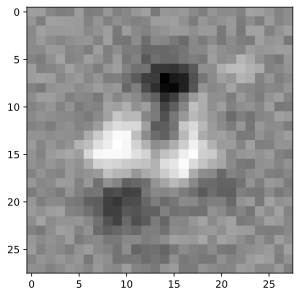

Época 36 de 100 => perda: 0.50600, acurária: 0.8743


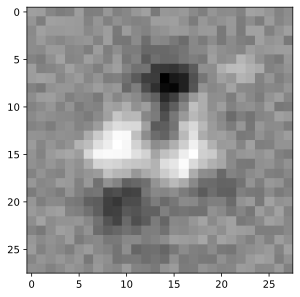

Época 37 de 100 => perda: 0.50195, acurária: 0.8749


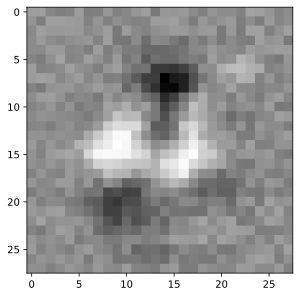

Época 38 de 100 => perda: 0.49808, acurária: 0.8755


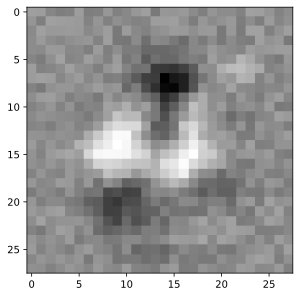

Época 39 de 100 => perda: 0.49438, acurária: 0.8760


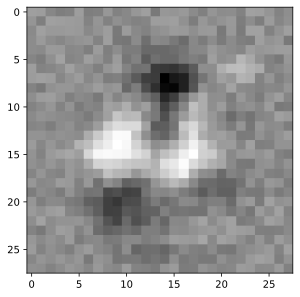

Época 40 de 100 => perda: 0.49083, acurária: 0.8766


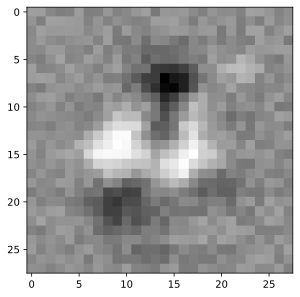

Época 41 de 100 => perda: 0.48743, acurária: 0.8772


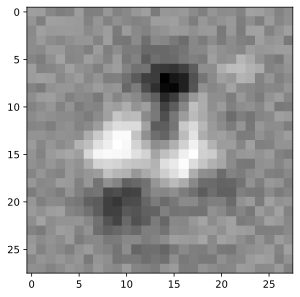

Época 42 de 100 => perda: 0.48416, acurária: 0.8778


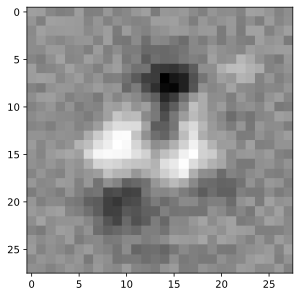

Época 43 de 100 => perda: 0.48101, acurária: 0.8781


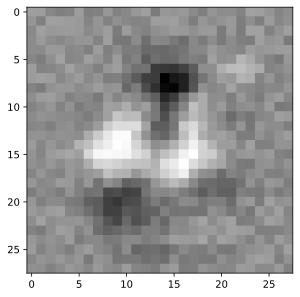

Época 44 de 100 => perda: 0.47799, acurária: 0.8788


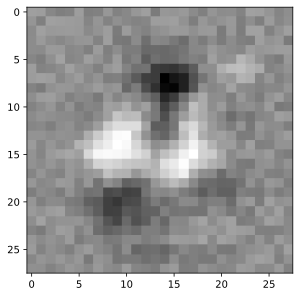

Época 45 de 100 => perda: 0.47507, acurária: 0.8794


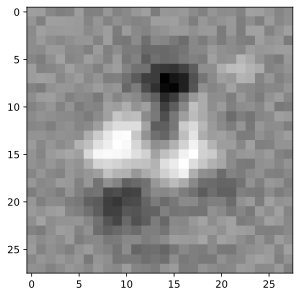

Época 46 de 100 => perda: 0.47226, acurária: 0.8799


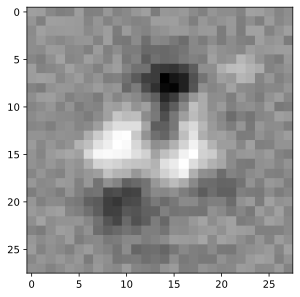

Época 47 de 100 => perda: 0.46955, acurária: 0.8804


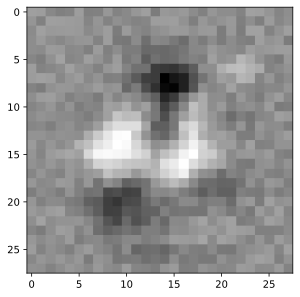

Época 48 de 100 => perda: 0.46693, acurária: 0.8805


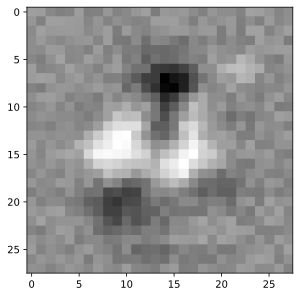

Época 49 de 100 => perda: 0.46440, acurária: 0.8809


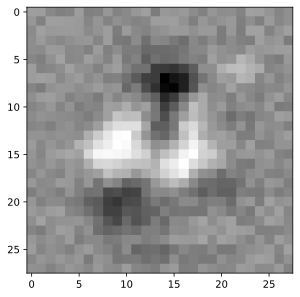

Época 50 de 100 => perda: 0.46195, acurária: 0.8813


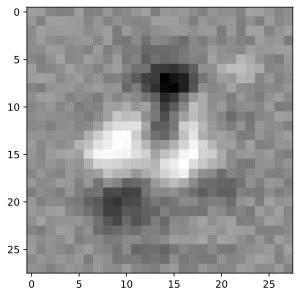

Época 51 de 100 => perda: 0.45958, acurária: 0.8817


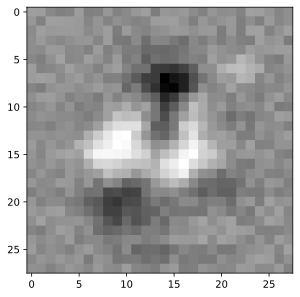

Época 52 de 100 => perda: 0.45729, acurária: 0.8820


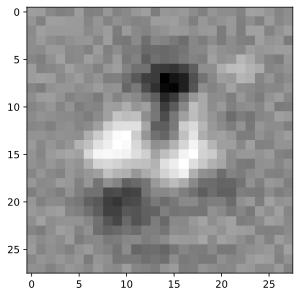

Época 53 de 100 => perda: 0.45506, acurária: 0.8823


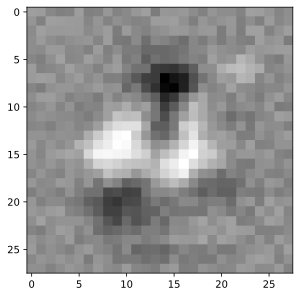

Época 54 de 100 => perda: 0.45291, acurária: 0.8828


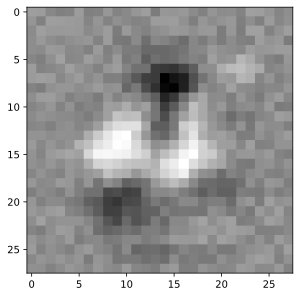

Época 55 de 100 => perda: 0.45081, acurária: 0.8832


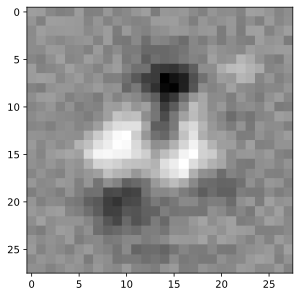

Época 56 de 100 => perda: 0.44878, acurária: 0.8837


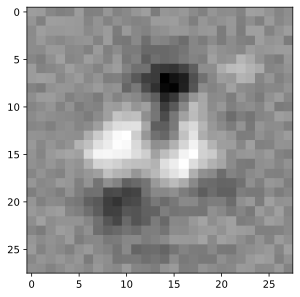

Época 57 de 100 => perda: 0.44681, acurária: 0.8842


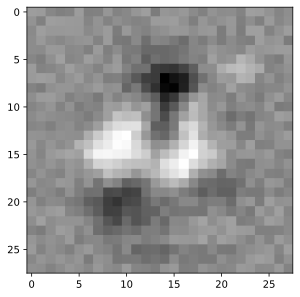

Época 58 de 100 => perda: 0.44489, acurária: 0.8844


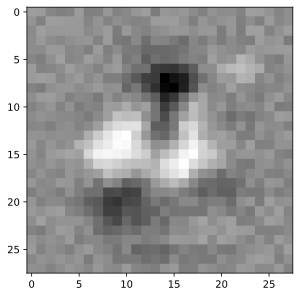

Época 59 de 100 => perda: 0.44302, acurária: 0.8849


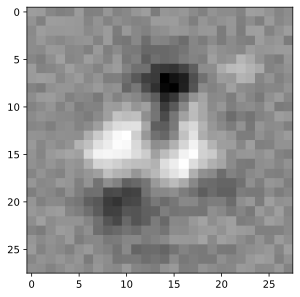

Época 60 de 100 => perda: 0.44120, acurária: 0.8851


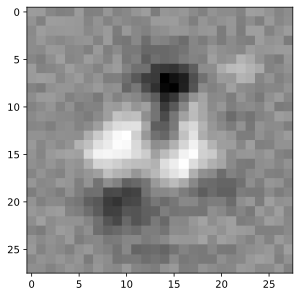

Época 61 de 100 => perda: 0.43943, acurária: 0.8855


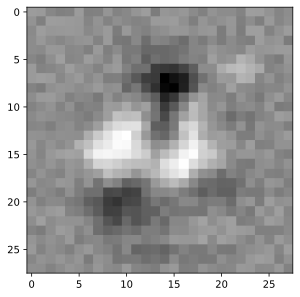

Época 62 de 100 => perda: 0.43771, acurária: 0.8858


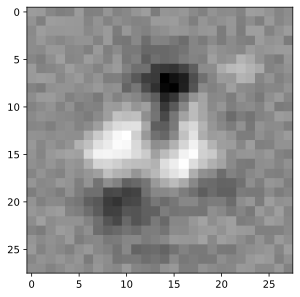

Época 63 de 100 => perda: 0.43603, acurária: 0.8862


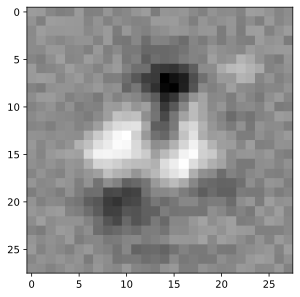

Época 64 de 100 => perda: 0.43440, acurária: 0.8864


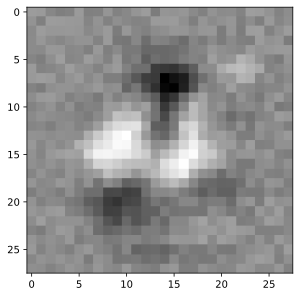

Época 65 de 100 => perda: 0.43280, acurária: 0.8867


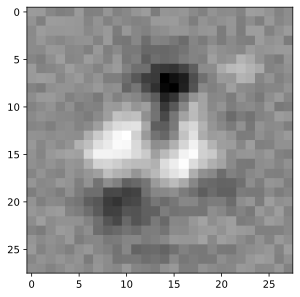

Época 66 de 100 => perda: 0.43124, acurária: 0.8870


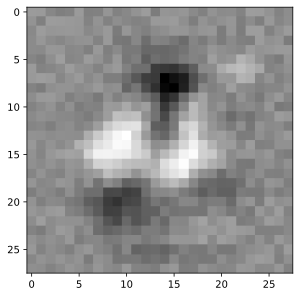

Época 67 de 100 => perda: 0.42972, acurária: 0.8872


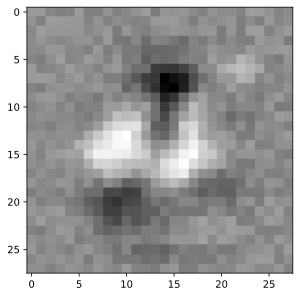

Época 68 de 100 => perda: 0.42824, acurária: 0.8875


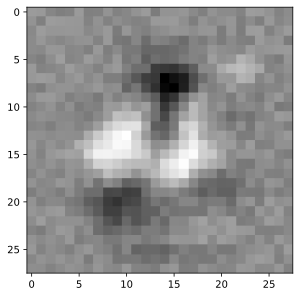

Época 69 de 100 => perda: 0.42679, acurária: 0.8878


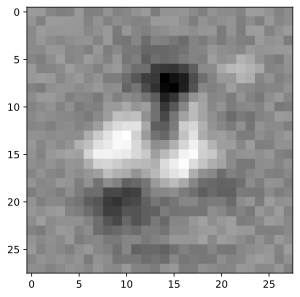

Época 70 de 100 => perda: 0.42537, acurária: 0.8880


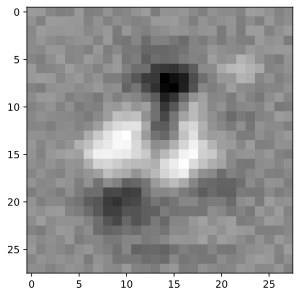

Época 71 de 100 => perda: 0.42399, acurária: 0.8884


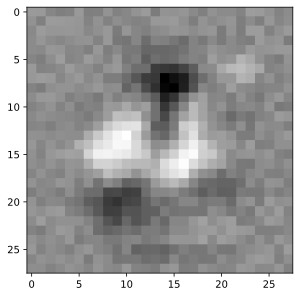

Época 72 de 100 => perda: 0.42264, acurária: 0.8886


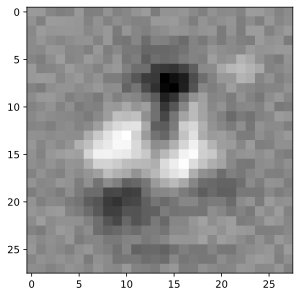

Época 73 de 100 => perda: 0.42131, acurária: 0.8889


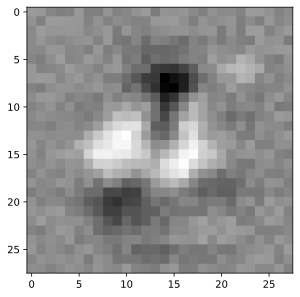

Época 74 de 100 => perda: 0.42002, acurária: 0.8891


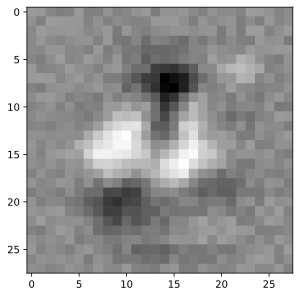

Época 75 de 100 => perda: 0.41875, acurária: 0.8894


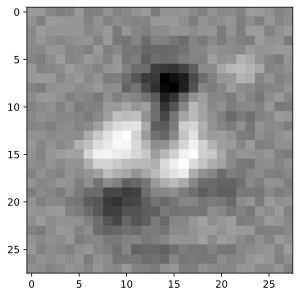

Época 76 de 100 => perda: 0.41751, acurária: 0.8897


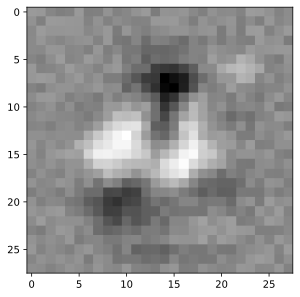

Época 77 de 100 => perda: 0.41629, acurária: 0.8900


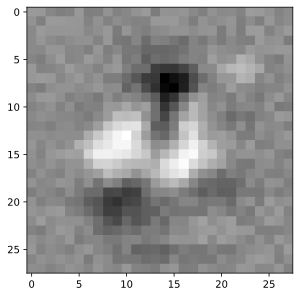

Época 78 de 100 => perda: 0.41510, acurária: 0.8902


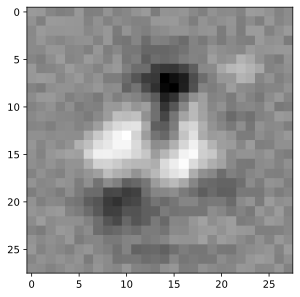

Época 79 de 100 => perda: 0.41393, acurária: 0.8903


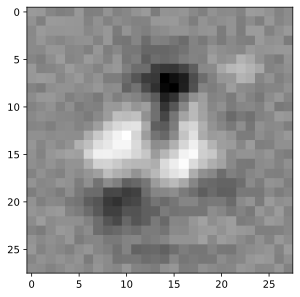

Época 80 de 100 => perda: 0.41279, acurária: 0.8904


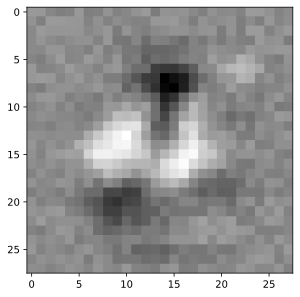

Época 81 de 100 => perda: 0.41166, acurária: 0.8906


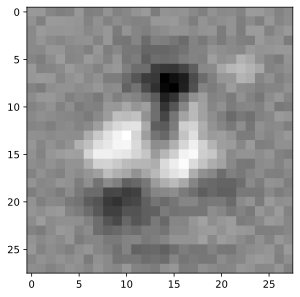

Época 82 de 100 => perda: 0.41056, acurária: 0.8908


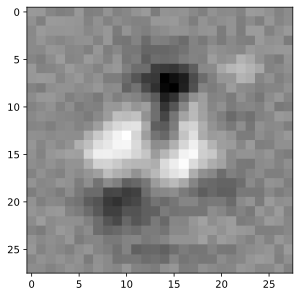

Época 83 de 100 => perda: 0.40948, acurária: 0.8910


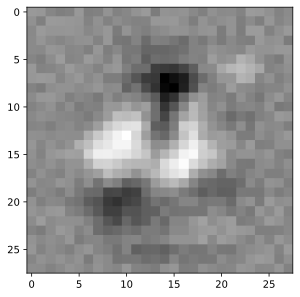

Época 84 de 100 => perda: 0.40842, acurária: 0.8913


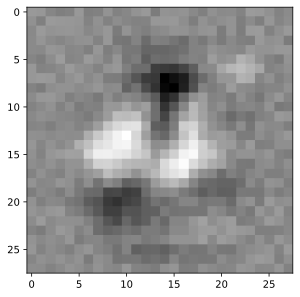

Época 85 de 100 => perda: 0.40738, acurária: 0.8915


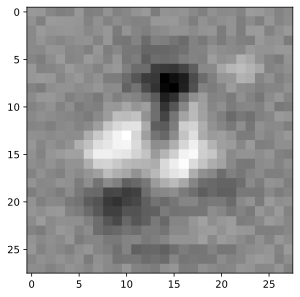

Época 86 de 100 => perda: 0.40636, acurária: 0.8918


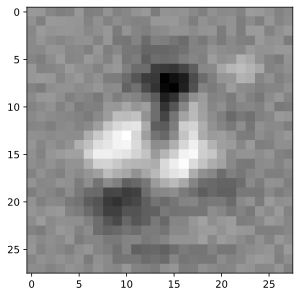

Época 87 de 100 => perda: 0.40536, acurária: 0.8920


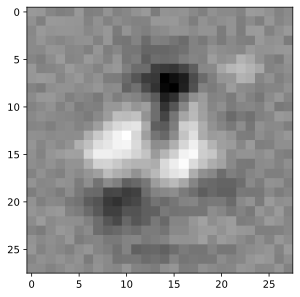

Época 88 de 100 => perda: 0.40438, acurária: 0.8922


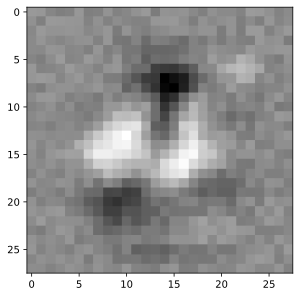

Época 89 de 100 => perda: 0.40341, acurária: 0.8924


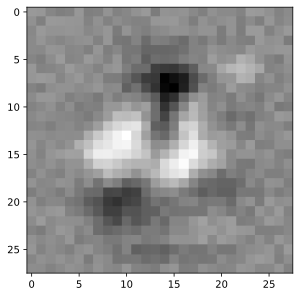

Época 90 de 100 => perda: 0.40246, acurária: 0.8926


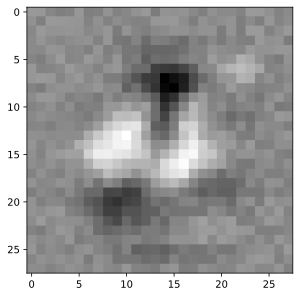

Época 91 de 100 => perda: 0.40153, acurária: 0.8928


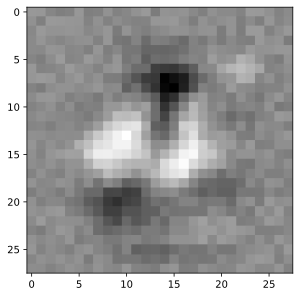

Época 92 de 100 => perda: 0.40061, acurária: 0.8931


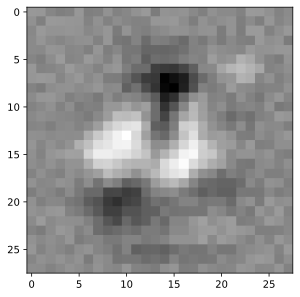

Época 93 de 100 => perda: 0.39971, acurária: 0.8932


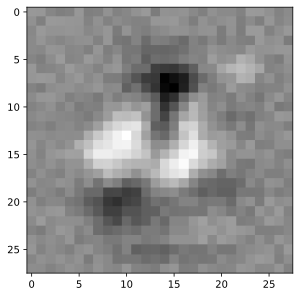

Época 94 de 100 => perda: 0.39882, acurária: 0.8935


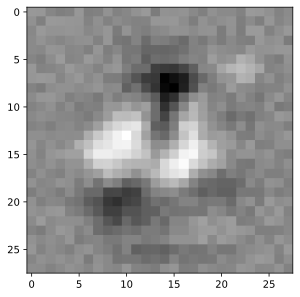

Época 95 de 100 => perda: 0.39794, acurária: 0.8937


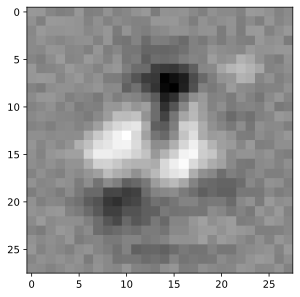

Época 96 de 100 => perda: 0.39709, acurária: 0.8939


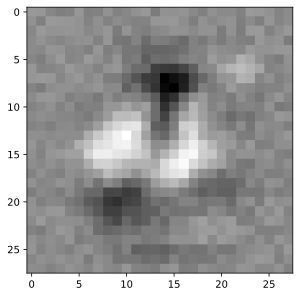

Época 97 de 100 => perda: 0.39624, acurária: 0.8941


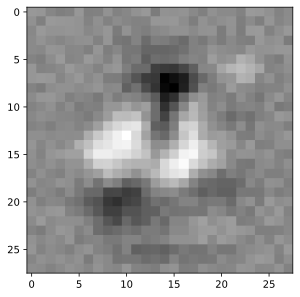

Época 98 de 100 => perda: 0.39541, acurária: 0.8942


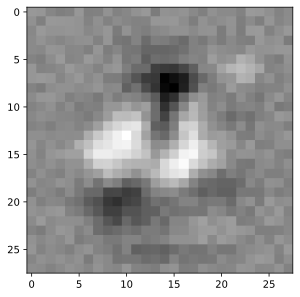

Época 99 de 100 => perda: 0.39459, acurária: 0.8943


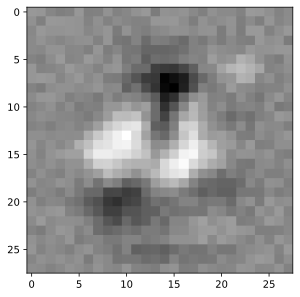

Época 100 de 100 => perda: 0.39379, acurária: 0.8945


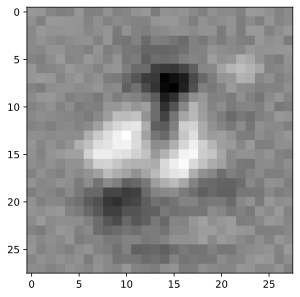

Tempo de treinamento: 43.97 segundos


In [15]:
import numpy
import time

losses = []
zs = []

start = time.time()

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    ## Exercício 1
    print(f'Época {i+1} de {epochs} => perda: {loss.data:.5f}, acurária: {accuracy:.4f}')

    ## Exercício 2: Visualizando pesos da classe 4
    weights = model.state_dict()['weight']

    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

stop = time.time()
print(f'Tempo de treinamento: {stop - start:.2f} segundos')

In [16]:
print('Final loss:', loss.item())

Final loss: 0.393785685300827


### Visualizando gráfico de perda durante o treinamento

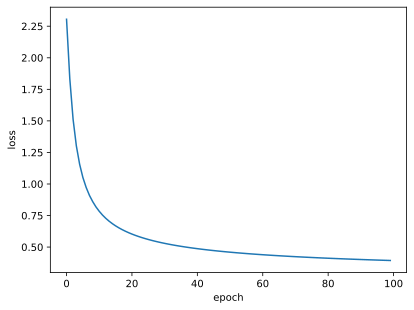

In [17]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.89465


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,5673,1,57,32,12,102,47,49,35,47
1,0,6506,79,39,35,66,31,93,181,42
2,24,33,5100,154,46,46,75,102,85,40
3,21,31,98,5300,4,235,5,24,179,102
4,14,6,132,7,5316,91,45,85,27,231
5,48,50,15,257,8,4406,89,11,175,43
6,57,11,128,46,67,116,5569,3,47,4
7,6,15,126,82,14,32,2,5656,36,203
8,72,80,178,135,52,227,53,19,4974,58


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


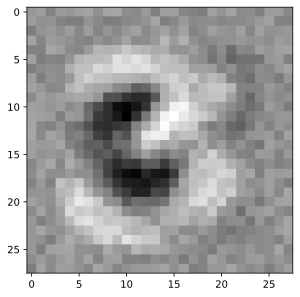

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

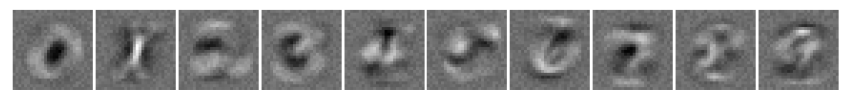

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [22]:
# Ver laço de treinamento implementado anteriormente

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [23]:
# Ver laço de treinamento implementado anteriormente

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?

**R:** São 60 mil imagens de tamanho 28 x 28 pixels, ou seja: [60000, 28, 28]

2. Qual é o shape da saída da rede?

**R:** 60 mil targets variando em 10 classes diferentes (algarismos de 0 a 9), ou seja: [60000, 10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?

**R:** 28 x 28 + 10 = 794

# Aprendizados
